import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [ ]:
columns_to_use = ['title', 'journal', 'publish_time', 'abstract', 'authors', 'source_x']
df = pd.read_csv('data/metadata.csv', usecols=columns_to_use, low_memory=False, nrows=10000)

df.head()

In [8]:
print("Shape (rows, columns):", df.shape)
df.info()

Shape (rows, columns): (10000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   source_x      10000 non-null  object
 1   title         10000 non-null  object
 2   abstract      7855 non-null   object
 3   publish_time  10000 non-null  object
 4   authors       9406 non-null   object
 5   journal       9953 non-null   object
dtypes: object(6)
memory usage: 468.9+ KB


In [9]:
df.isnull().sum().sort_values(ascending=False)

abstract        2145
authors          594
journal           47
source_x           0
title              0
publish_time       0
dtype: int64

In [10]:
df.describe(include='all')

,source_x,title,abstract,publish_time,authors,journal
count,10000,10000,7855,10000,9406,9953
unique,1,9898,7836,4160,9188,2064
top,PMC,Inhaltsverzeichnis,This article is one of ten reviews selected fr...,2002-11-13,The Lancet,PLoS One
freq,10000,7,9,86,23,697


# Standardize column names to lowercase with underscores
df = df.rename(columns={c: c.strip().lower().replace(" ", "_") for c in df.columns})

# Convert publish_time to datetime, create year column
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['year'] = df['publish_time'].dt.year

df[['publish_time', 'year']].head()

In [13]:
df['title'] = df['title'].fillna("Untitled")
df['journal'] = df['journal'].fillna("Unknown")
df['abstract'] = df['abstract'].fillna("")
df['authors'] = df['authors'].fillna("Unknown")

In [14]:
df['abstract_word_count'] = df['abstract'].str.split().str.len()
df[['abstract_word_count']].describe()

,abstract_word_count
count,10000.000000
mean,159.686100
std,172.076274
min,0.000000
25%,68.000000
50%,175.000000
75%,236.000000
max,12745.000000


In [15]:
df_clean = df.dropna(subset=['publish_time']).copy()
print("Original rows:", len(df), "| Cleaned rows:", len(df_clean))

Original rows: 10000 | Cleaned rows: 9078


In [16]:
df_clean.to_csv('data/metadata_clean_sample.csv', index=False)
print("Saved to data/metadata_clean_sample.csv")

Saved to data/metadata_clean_sample.csv


year_counts = df_clean['year'].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.bar(year_counts.index.astype(int), year_counts.values, color="#1f77b4")
plt.title("Publications by Year")
plt.xlabel("Year")
plt.ylabel("Number of publications")
plt.tight_layout()
plt.show()

C:\Users\lapto\AppData\Local\Temp\ipykernel_5216\3514039266.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_journals.values, y=top_journals.index, palette="Blues_d")


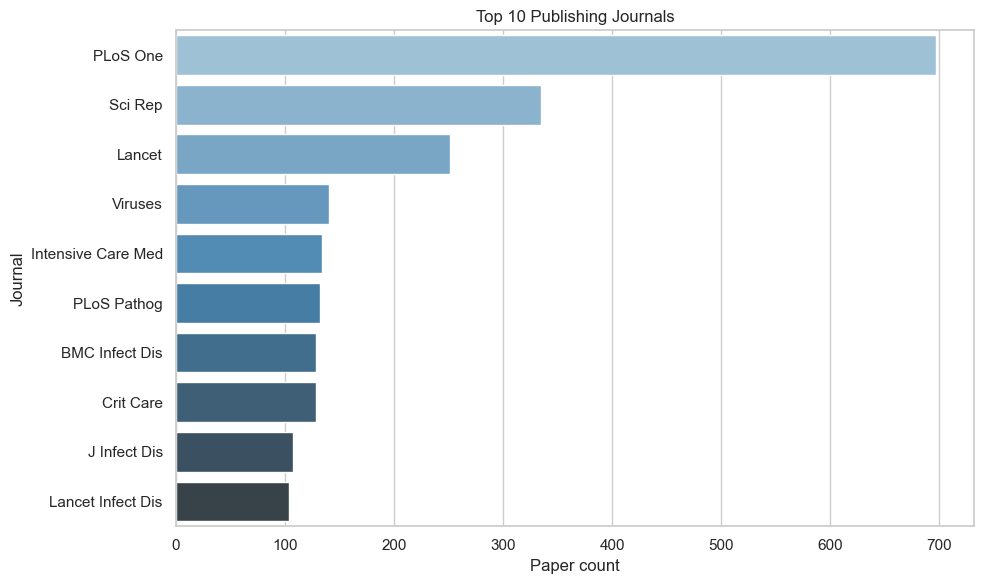

In [17]:
top_n = 10
top_journals = df_clean['journal'].value_counts().head(top_n)

plt.figure(figsize=(10,6))
sns.barplot(x=top_journals.values, y=top_journals.index, palette="Blues_d")
plt.title(f"Top {top_n} Publishing Journals")
plt.xlabel("Paper count")
plt.ylabel("Journal")
plt.tight_layout()
plt.show()

C:\Users\lapto\AppData\Local\Temp\ipykernel_5216\885914801.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_counts.index, y=source_counts.values, palette="Greens_d")


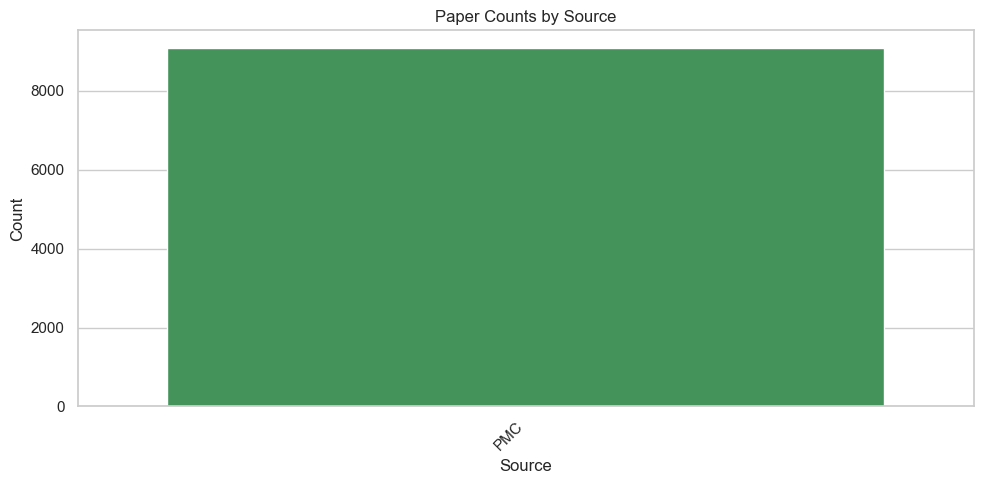

In [18]:
source_col = 'source_x' if 'source_x' in df_clean.columns else None
if source_col:
    source_counts = df_clean[source_col].fillna("Unknown").value_counts()

    plt.figure(figsize=(10,5))
    sns.barplot(x=source_counts.index, y=source_counts.values, palette="Greens_d")
    plt.title("Paper Counts by Source")
    plt.xlabel("Source")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No source column available in this sample.")

In [19]:
import re
from collections import Counter

titles = df_clean['title'].astype(str).str.lower().tolist()
words = []
for t in titles:
    words.extend(re.findall(r"[a-z]+", t))

stop = set(["the","and","of","in","to","a","for","on","with","from","by","an","is","are","as","at","into","during","covid","sars","cov","coronavirus"])
words = [w for w in words if w not in stop and len(w) > 2]

top_words = Counter(words).most_common(25)
top_words

[('virus', 1344),
 ('influenza', 845),
 ('infection', 668),
 ('respiratory', 541),
 ('human', 519),
 ('disease', 443),
 ('patients', 429),
 ('cell', 416),
 ('viral', 402),
 ('acute', 372),
 ('protein', 364),
 ('cells', 363),
 ('analysis', 353),
 ('health', 349),
 ('study', 340),
 ('infections', 284),
 ('syndrome', 267),
 ('against', 264),
 ('associated', 259),
 ('clinical', 251),
 ('induced', 243),
 ('based', 242),
 ('pandemic', 237),
 ('infectious', 229),
 ('novel', 226)]

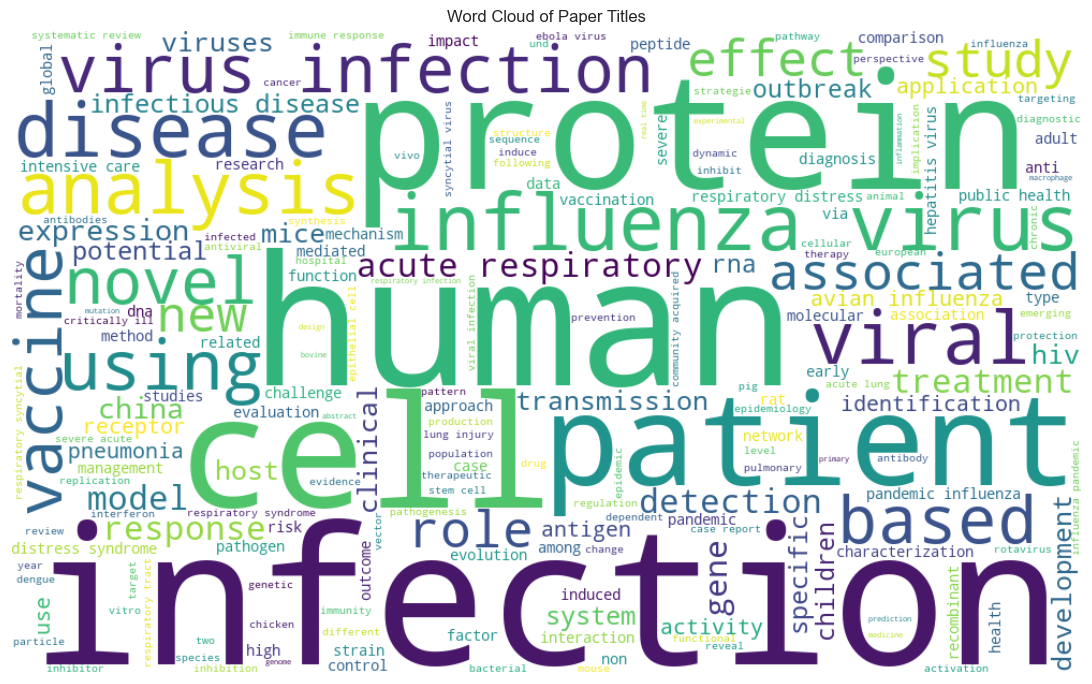

In [20]:
from wordcloud import WordCloud

text = " ".join([w for w, _ in top_words])
wc = WordCloud(width=1000, height=600, background_color="white").generate(" ".join(words))

plt.figure(figsize=(12,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Paper Titles")
plt.tight_layout()
plt.show()